# Algorithm step-by-step visual explanation

In [1]:
import matplotlib.pyplot as plt
import random

from daugman_visual_explanation import DaugmanVisualExplanation
from daugman import find_iris

In [2]:
# fixed size for matplotlib output
plt.rcParams['figure.figsize'] = [5, 5]
# for replicability
random.seed(2020)

dve = DaugmanVisualExplanation('eye.jpg')

## The Daugman's part

Daugman algorithm measures the difference in average pixel intensities on a grayscale image for a bunch of circles with the same center and different radius.

The idea is to find the biggest drop in intensity values between two neighbor circles. It should imply the transition between the iris and its surroundings.

E.g., on the below image, yellow, green, and red circles have the same pixel intensities because all pixels underneath are black. Thus deltas (difference) between all those intensities are 0 (yellow-green, green-red). But pixels under the blue circle are all white, so the red-blue difference is the highest, which means that the red circle is the best guess for the iris border. In case we had not a red circle, the green-blue difference would have the highest difference, thus the green circle would have been chosen.

Ideally, for best accuracy, the step between circles radii should be 1px.

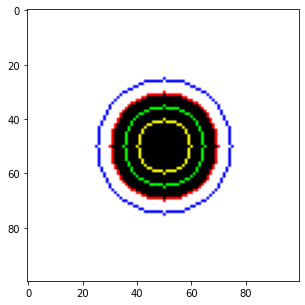

In [3]:
dve.plot_pixel_intensity_delta_pic()

Also, it is not hard to see that the central point selection is very important and for best accuracy, we need to check every single point on the image. It is computationally expensive, so we need to find a way to reduce the number of potential points.

One more thing: to avoid false-positive results, the algorithm applies a GaussianBlur filter on all collected deltas for a single potential iris center, it reduces noise and makes results smoother.

## Find iris part

In order to reduce the number of potential points, we will imply, that the iris cannot be larger than 1/3 of the image side if the eye is properly cropped.

So, we do not have to check every pixel on the image, only those, which are in the central 1/3 of the image:

```
0 0 0
0 1 0
0 0 0
```

For each of these dots, we will need to run the Daugman algorithm. In this example, we will take only every 3rd point for clarity. Thereby we will have x3 speed up, with slightly lower accuracy.

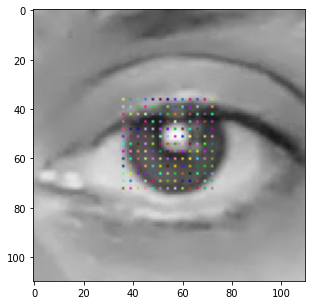

In [4]:
# plot all potential iris centers
img_dot = dve.plot_all_potential_iris_centers()

Also, we presume, that iris could not be less than a circle with a certain radius, let's say 10px, and also it could not be more than a certain radius, let's say 30px.

Now for each circle between min and max radius with the step 2px, we will take all pixel values and sum them up.

We selected 2px radii step for plotting clarity.

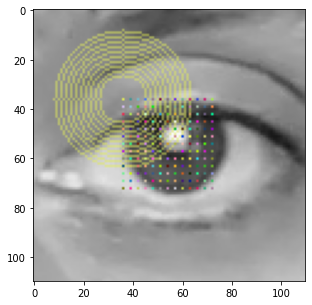

In [5]:
img_circles = dve.plot_circles_for_one_center(img_dot, dot_idx=0)

Daugman will find the best iris candidate among those circles, for that point

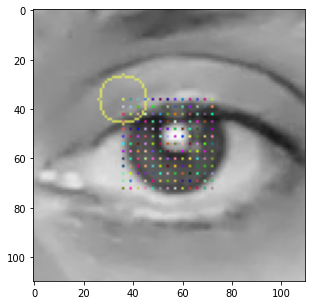

In [6]:
_ = dve.plot_best_circle_for_a_few_potential_iris_centers(img_dot, [0])

Let's do the same thing for every 20th potential iris point

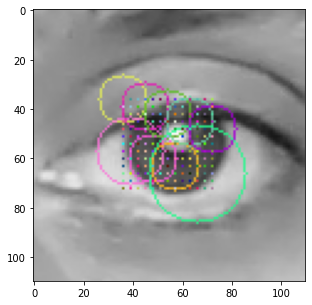

In [7]:
# plot best circle for every 20th potential iris center
_ = dve.plot_best_circle_for_a_few_potential_iris_centers(img_dot, range(0, len(dve.all_points), 20))

And now for each potential point. The resulting image is hard to perceive, but the best iris candidate will be selected among plotted circles.

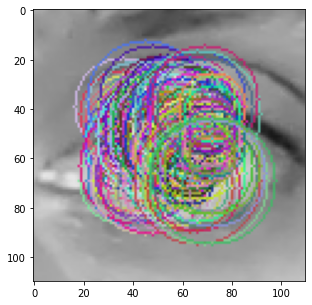

In [8]:
# plot best circle for every 20th potential iris center
_ = dve.plot_best_circle_for_a_few_potential_iris_centers(img_dot, range(0, len(dve.all_points)))

It will be the circle with the highest value (biggest delta). With selected parameters, it would be the result below:

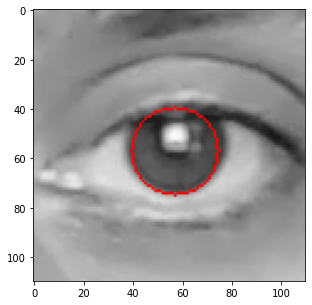

In [9]:
_ = dve.find_iris(daugman_start=10, daugman_end=30, daugman_step=2, points_step=3)

If we only change the radii step from 2px to 1px, we will get a better result but x2 slower:

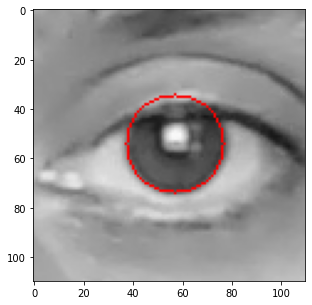

In [10]:
_ = dve.find_iris(daugman_start=10, daugman_end=30, daugman_step=1, points_step=3)

The most computationally expensive and potentially most accurate variant:

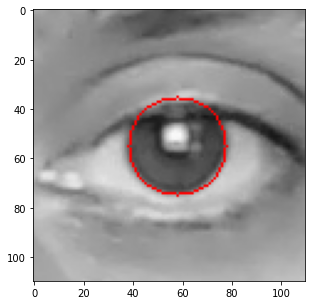

In [11]:
_ = dve.find_iris(daugman_start=10, daugman_end=50, daugman_step=1, points_step=1)

## Playground

Play with parameters to get an intuition

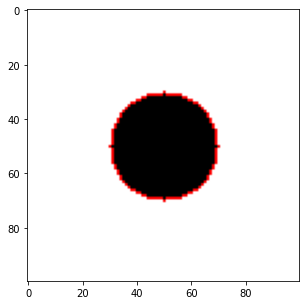

In [12]:
dve.find_iris_on_binary_image(daugman_start=10, daugman_end=30, daugman_step=2, points_step=1)

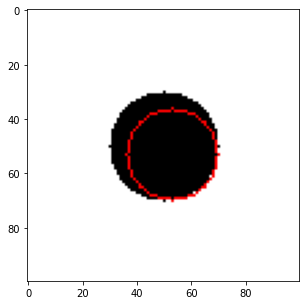

In [13]:
dve.find_iris_on_binary_image(daugman_start=10, daugman_end=30, daugman_step=1, points_step=10)

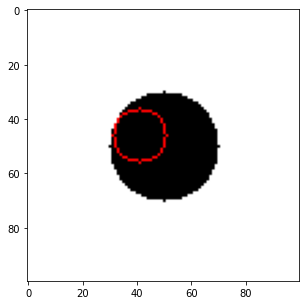

In [14]:
dve.find_iris_on_binary_image(daugman_start=10, daugman_end=30, daugman_step=10, points_step=1)